In [1]:
import gpmp.num as gnp
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from src.point_cloud import Cloud
from src.functions import goldstein_price
from src.utils import compute_convex_lower_hull

if gnp._gpmp_backend_ == "torch":
    import torch

Using backend: torch


In [2]:
# set seed for reproductability
if gnp._gpmp_backend_ == "torch":
    torch.manual_seed(0)
np.random.seed(0)

The cloud is built using the Goldstein-Price in dimension $d=2$, it is possible to use another function but you must specify its dimension and the bounds of the domain.

In [3]:
# Goldstein Price function

# dimension of the design
d = 2

# bound of the domain
x_min = gnp.array([-5, 0])
x_max = gnp.array([10, 15])

# Regularity of the GP model 
p = 2

First define the class for the cloud, the design of experiment is constructed as well as the GP model. The GP model depends on a hyperparameter $\theta$ and it is selected by maximum restricted likelihood $\theta_{\rm REML}$.

In [10]:
cloud_points = Cloud(d, p, x_min, x_max, goldstein_price)

Define the bounds $(a, b)\in \mathbb{R}^{d+1}\times\mathbb{R}^{d+1}$ to choose the value of $\theta$ randomly, where $b > 0$. For instance in dimension $d=2$, $\theta = (\sigma, \rho_0, \rho_1)$ and $\theta$ will be chosen uniformly in:
$$
    I_{\theta} = [\theta_{\rm REML} - b_0, \theta_{\rm REML} + a_0 - b_0]\times[\theta_{\rm REML} - b_1, \theta_{\rm REML} + a_0 - b_1]\times[\theta_{\rm REML} - b_2, \theta_{\rm REML} + a_0 - b_2] 
$$

In [4]:
# bounds for GP parameters when computing the cloud
a0, b0 = 0.5, -0.4
a1, b1 = 0.3, -0.2
a2, b2 = 0.3, -0.2
a = [a0, a1, a2]
b = [b0, b1, b2]

Then compute the metrics for the J+GP method and for the prediction by a GP model with parameter $\theta$ when it is choosed uniformly in $I_{\theta}$. 

In [6]:
cloud_points.j_plus_gp_point()
cloud_points.compute_cloud_points(a, b)

Compute the convex hull of the cloud to find the inaccessible area for prediction by GP.

In [7]:
# compute the convex hull
x_curve, lower_curve = compute_convex_lower_hull(gnp.asarray(cloud_points.rmse_res), gnp.asarray(cloud_points.iae_alpha_res), yliminf=0.19, xlim=5.5e10, ylimsup=0.22, nb_p=2*10)

x_curve_loo, lower_curve_loo = compute_convex_lower_hull(gnp.asarray(cloud_points.rmse_resloo), gnp.asarray(cloud_points.iae_alpha_resloo),  yliminf=0.2, nb_p=2*10)

Finally display the cloud.

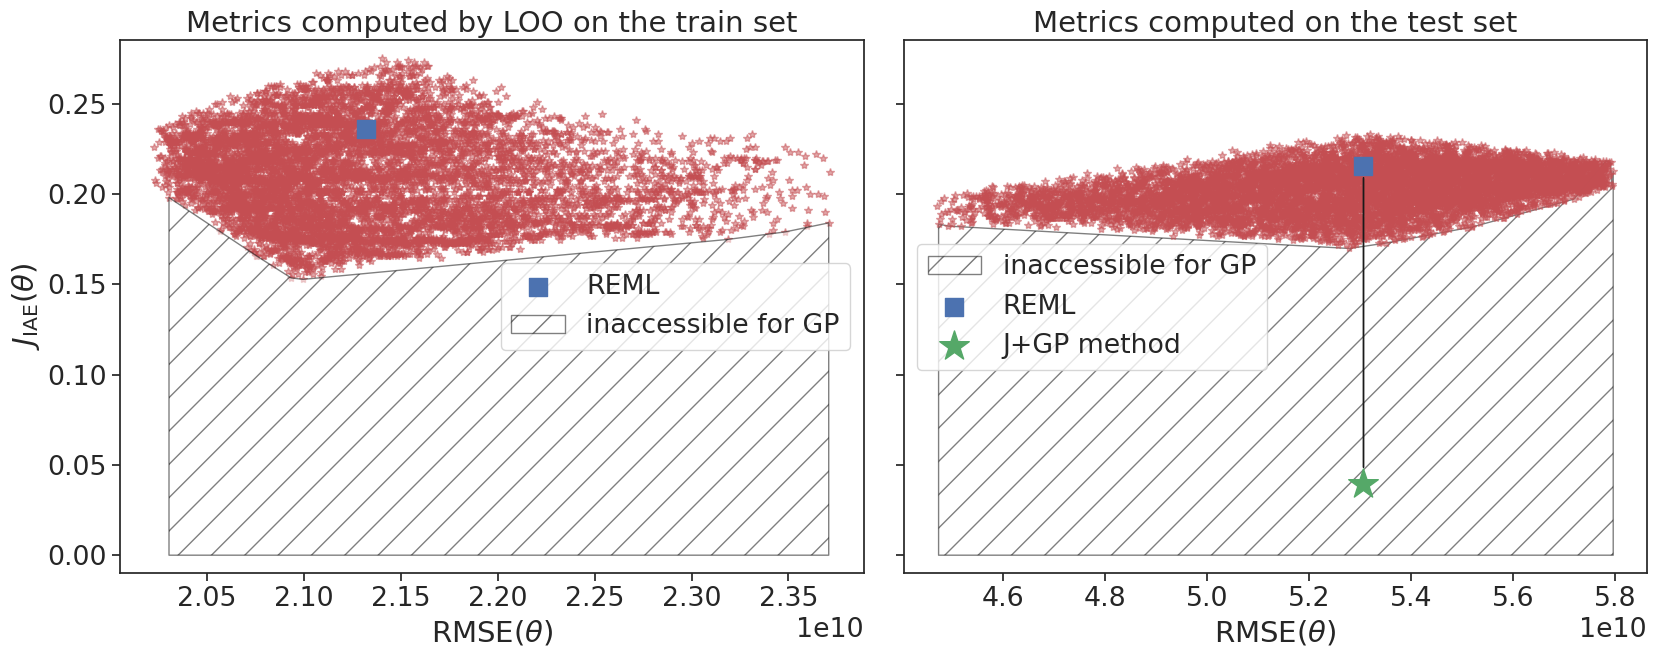

In [8]:
# display the cloud
sns.set_theme(style="ticks", font_scale=1.75)
fig, axs = plt.subplots(1, 2, figsize=(17,  7), sharey=True)

axs[0].plot(cloud_points.rmse_resloo, cloud_points.iae_alpha_resloo, "r*", alpha=0.5, zorder=-1)
axs[0].scatter(cloud_points.rmse_remlloo, cloud_points.iae_alpha_remlloo, s=150, c="b", marker="s", zorder=1, label="REML")

axs[0].set_xlabel(r"RMSE$(\theta)$")
axs[0].set_ylabel(r"$J_{\rm IAE}(\theta)$")

axs[0].set_title("Metrics computed by LOO on the train set")

axs[0].fill_between(x_curve_loo, lower_curve_loo, 0, hatch="/", alpha=0.5, color='white', edgecolor='black', zorder=-1, label="inaccessible for GP")
axs[0].legend()

axs[1].set_ylim(-0.01, np.max(cloud_points.iae_alpha_resloo)+0.01)
axs[1].fill_between(x_curve, lower_curve, 0, hatch="/", alpha=0.5, color='white', edgecolor='black', zorder=-1, label="inaccessible for GP")

axs[1].scatter(cloud_points.rmse_reml, cloud_points.iae_alpha_reml, s=150, c="b", marker="s", zorder=1, label="REML")
axs[1].scatter(cloud_points.rmse_reml, cloud_points.iae_j_plus_gp, s=500, c="g", marker="*", label="J+GP method", zorder=1)

axs[1].plot(cloud_points.rmse_res, cloud_points.iae_alpha_res, "r*", alpha=0.5, zorder=-1)
axs[1].set_xlabel(r"RMSE$(\theta)$")

axs[1].set_title("Metrics computed on the test set")


dy = cloud_points.iae_j_plus_gp - cloud_points.iae_alpha_reml
axs[1].arrow(cloud_points.rmse_reml, cloud_points.iae_alpha_reml-0.006, 0, dy+0.025, head_width=50, head_length=0.01, fc='k', ec='k')

axs[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
# save the figure
path_0 = "your_path"
fig.savefig(f'{path_0}/pareto_cp.pdf', bbox_inches='tight')